In [36]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset


In [37]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [38]:
!nvidia-smi

Mon Jun  2 19:32:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.90                 Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8              5W /   35W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [39]:
class Lenet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model=nn.Sequential(
            # Layer-1 (C1)
            nn.Conv2d(1,6,kernel_size=5),
            nn.Tanh(),
            # Layer-2 (S1)
            nn.AvgPool2d(kernel_size=2, stride=2),
            # Layer-3 (C2)
            nn.Conv2d(6,16,kernel_size=5),
            nn.Tanh(),
            # Layer-4 (S4)
            nn.AvgPool2d(kernel_size=2,stride=2),
            # Layer-5 (Flatten and Linear)
            nn.Flatten(),
            nn.Linear(400,120, bias=True),
            nn.Tanh(),
            # Layer-6 (Linear) 
            nn.Linear(120,84,bias=True),
            nn.Tanh(),
            # Layer-7 (Linear)
            nn.Linear(84,num_classes,bias=True)
             
        )
    
    def forward(self,x):
        return self.model(x)
    

### LeNet-5 Implementation on MNIST Dataset

In [40]:
transform=transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(0.1383,0.2935)
    
])

training_dataset=datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testing_dataset=datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [ ]:

# Compute mean and std for normalization

# training_loader = DataLoader(training_dataset, batch_size=64, shuffle=True)
# images, _ = next(iter(training_dataset))
# mean = images.mean().item()
# std = images.std().item()

# print(f"Mean: {mean}, Std: {std}")


Mean: 0.1383846551179886, Std: 0.29352882504463196


In [41]:
len(training_dataset[0])

2

In [8]:
type(training_dataset[0])

tuple

In [9]:
training_dataset[0][0].shape

torch.Size([1, 32, 32])

In [42]:
# Check unique labels in the training dataset
labels = [training_dataset[i][1] for i in range(len(training_dataset))]
unique_labels = set(labels)
print("Unique labels:", sorted(unique_labels))
print("Number of unique labels:", len(unique_labels))
print("Min label:", min(unique_labels))
print("Max label:", max(unique_labels))

Unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Number of unique labels: 10
Min label: 0
Max label: 9


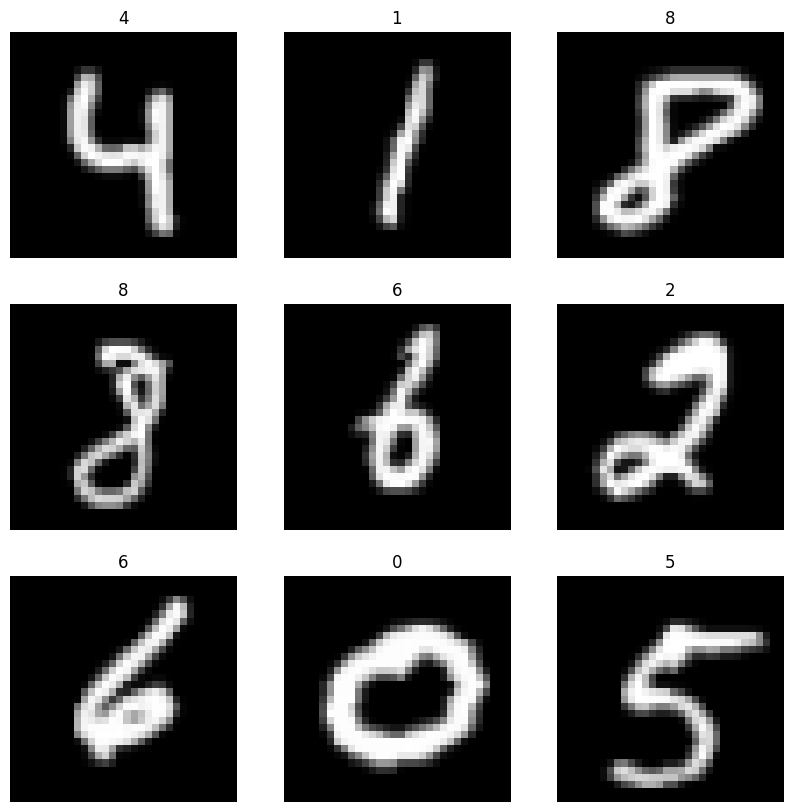

In [43]:
label_map={
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9"
}

rows, cols =3,3
figure= plt.figure(figsize=(10, 10))
for i in range(1, rows * cols + 1):
    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[label])
    plt.axis("off")
    plt.imshow(img.reshape(32,32), cmap="gray")

In [44]:
train_loader=DataLoader(
    dataset=training_dataset,
    batch_size=64,
    shuffle=True
)

test_loader=DataLoader(
    dataset=testing_dataset,
    batch_size=64,
    shuffle=False
)

In [45]:
model=Lenet(num_classes=10).to(device)
epochs=20
learning_rate=0.001
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model.parameters(),lr=learning_rate)

In [46]:
summary(model, input_size=(64, 1, 32, 32), device=device.type)

Layer (type:depth-idx)                   Output Shape              Param #
Lenet                                    [64, 10]                  --
├─Sequential: 1-1                        [64, 10]                  --
│    └─Conv2d: 2-1                       [64, 6, 28, 28]           156
│    └─Tanh: 2-2                         [64, 6, 28, 28]           --
│    └─AvgPool2d: 2-3                    [64, 6, 14, 14]           --
│    └─Conv2d: 2-4                       [64, 16, 10, 10]          2,416
│    └─Tanh: 2-5                         [64, 16, 10, 10]          --
│    └─AvgPool2d: 2-6                    [64, 16, 5, 5]            --
│    └─Flatten: 2-7                      [64, 400]                 --
│    └─Linear: 2-8                       [64, 120]                 48,120
│    └─Tanh: 2-9                         [64, 120]                 --
│    └─Linear: 2-10                      [64, 84]                  10,164
│    └─Tanh: 2-11                        [64, 84]                  --
│  

In [47]:
training_loss = []
for epoch in range(epochs):
    total_loss = 0
    num_batches = 0
    model.train()
    
    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)
        output = model(features)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    training_loss.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {avg_loss:.4f}")

Epoch [1/20], Avg Loss: 2.2490
Epoch [2/20], Avg Loss: 2.0923
Epoch [3/20], Avg Loss: 1.7765
Epoch [4/20], Avg Loss: 1.4049
Epoch [5/20], Avg Loss: 1.1078
Epoch [6/20], Avg Loss: 0.9128
Epoch [7/20], Avg Loss: 0.7841
Epoch [8/20], Avg Loss: 0.6943
Epoch [9/20], Avg Loss: 0.6282
Epoch [10/20], Avg Loss: 0.5774
Epoch [11/20], Avg Loss: 0.5369
Epoch [12/20], Avg Loss: 0.5038
Epoch [13/20], Avg Loss: 0.4763
Epoch [14/20], Avg Loss: 0.4528
Epoch [15/20], Avg Loss: 0.4326
Epoch [16/20], Avg Loss: 0.4151
Epoch [17/20], Avg Loss: 0.3998
Epoch [18/20], Avg Loss: 0.3860
Epoch [19/20], Avg Loss: 0.3737
Epoch [20/20], Avg Loss: 0.3627


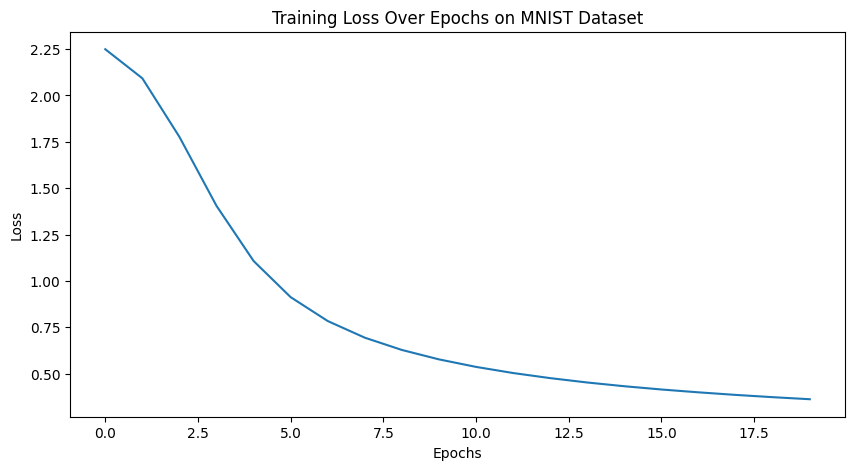

In [48]:
plt.figure(figsize=(10, 5))
plt.title("Training Loss Over Epochs on MNIST Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.plot(training_loss)

In [49]:
correct = 0
total = 0

with torch.no_grad():
    model.eval()
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')


Accuracy of the model on the test set: 90.58%


### LeNet-5 Implementation on EMNIST Dataset

Unique labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
Number of unique labels: 26
Min label: 1
Max label: 26


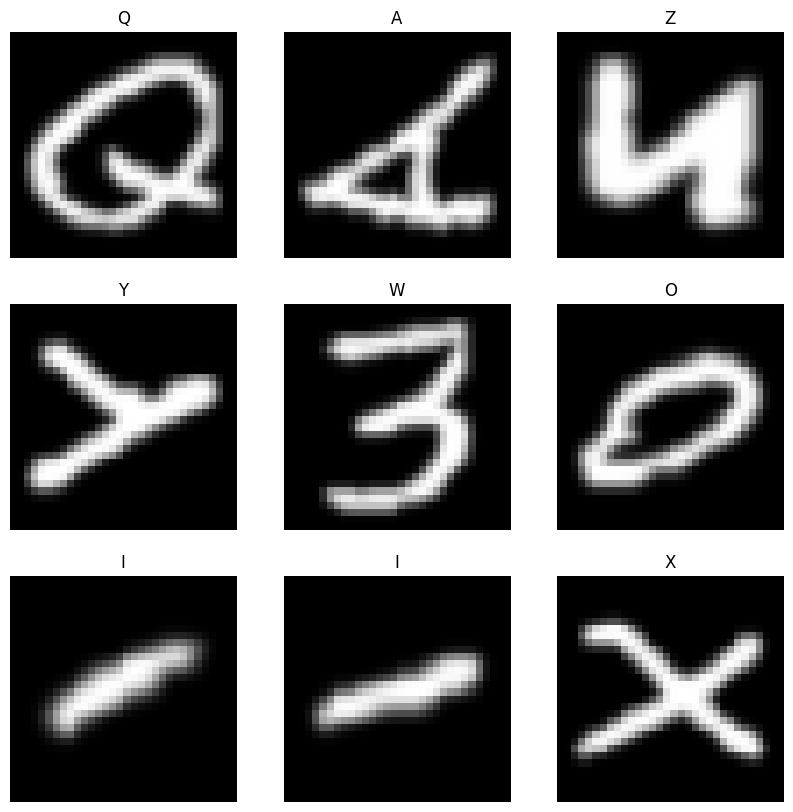

In [ ]:
EMNIST_transform=transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    
    
])

training_dataset=datasets.EMNIST(
    root='./data',
    train=True,
    split='letters',
    download=True,
    transform=EMNIST_transform
)

testing_dataset=datasets.EMNIST(
    root='./data',
    train=False,
    split='letters',
    download=True,
    transform=EMNIST_transform

)

# Check unique labels in the training dataset
labels = [training_dataset[i][1] for i in range(len(training_dataset))]
unique_labels = set(labels)
print("Unique labels:", sorted(unique_labels))
print("Number of unique labels:", len(unique_labels))
print("Min label:", min(unique_labels))
print("Max label:", max(unique_labels))


from torch.utils.data import Dataset, DataLoader

class ZeroIndexedEMNIST(Dataset):
    def __init__(self, emnist_dataset):
        self.emnist_dataset = emnist_dataset

    def __getitem__(self, idx):
        img, label = self.emnist_dataset[idx]
        return img, label - 1  # Convert 1-26 to 0-25

    def __len__(self):
        return len(self.emnist_dataset)

train_dataset = ZeroIndexedEMNIST(training_dataset)
test_dataset = ZeroIndexedEMNIST(testing_dataset)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


label_map={
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J',
    10: 'K',
    11: 'L',
    12: 'M',
    13: 'N',
    14: 'O',
    15: 'P',
    16: 'Q',
    17: 'R',
    18: 'S',
    19: 'T',
    20: 'U',
    21: 'V',
    22: 'W',
    23: 'X',
    24: 'Y',
    25: 'Z'
}

rows, cols =3,3
figure= plt.figure(figsize=(10, 10))
for i in range(1, rows * cols + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[label])
    plt.axis("off")
    plt.imshow(img.reshape(32,32), cmap="gray")


model=Lenet(num_classes=26).to(device)
epochs=20
learning_rate=0.001
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model.parameters(),lr=learning_rate)



In [19]:
summary(model, input_size=(64, 1, 32, 32), device=device.type)

Layer (type:depth-idx)                   Output Shape              Param #
Lenet                                    [64, 26]                  --
├─Sequential: 1-1                        [64, 26]                  --
│    └─Conv2d: 2-1                       [64, 6, 28, 28]           156
│    └─Tanh: 2-2                         [64, 6, 28, 28]           --
│    └─AvgPool2d: 2-3                    [64, 6, 14, 14]           --
│    └─Conv2d: 2-4                       [64, 16, 10, 10]          2,416
│    └─Tanh: 2-5                         [64, 16, 10, 10]          --
│    └─AvgPool2d: 2-6                    [64, 16, 5, 5]            --
│    └─Flatten: 2-7                      [64, 400]                 --
│    └─Linear: 2-8                       [64, 120]                 48,120
│    └─Tanh: 2-9                         [64, 120]                 --
│    └─Linear: 2-10                      [64, 84]                  10,164
│    └─Tanh: 2-11                        [64, 84]                  --
│  

In [20]:
training_loss = []
for epoch in range(epochs):
    total_loss = 0
    num_batches = 0
    model.train()
    
    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)
        output = model(features)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    training_loss.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {avg_loss:.4f}")

Epoch [1/20], Avg Loss: 3.2567
Epoch [2/20], Avg Loss: 3.2419
Epoch [3/20], Avg Loss: 3.2070
Epoch [4/20], Avg Loss: 3.0948
Epoch [5/20], Avg Loss: 2.8026
Epoch [6/20], Avg Loss: 2.4628
Epoch [7/20], Avg Loss: 2.2025
Epoch [8/20], Avg Loss: 2.0061
Epoch [9/20], Avg Loss: 1.8528
Epoch [10/20], Avg Loss: 1.7299
Epoch [11/20], Avg Loss: 1.6299
Epoch [12/20], Avg Loss: 1.5470
Epoch [13/20], Avg Loss: 1.4767
Epoch [14/20], Avg Loss: 1.4156
Epoch [15/20], Avg Loss: 1.3617
Epoch [16/20], Avg Loss: 1.3134
Epoch [17/20], Avg Loss: 1.2694
Epoch [18/20], Avg Loss: 1.2290
Epoch [19/20], Avg Loss: 1.1917
Epoch [20/20], Avg Loss: 1.1568


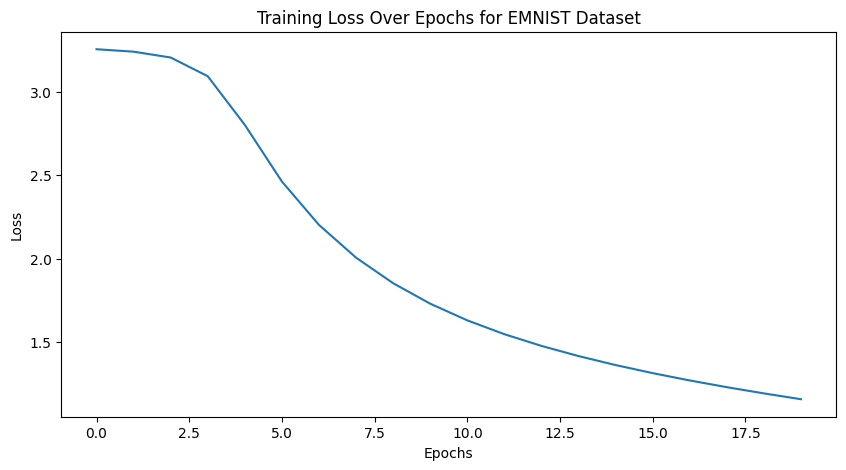

In [21]:
plt.figure(figsize=(10, 5))
plt.title("Training Loss Over Epochs for EMNIST Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.plot(training_loss)

In [22]:
correct = 0
total = 0

with torch.no_grad():
    model.eval()
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')


Accuracy of the model on the test set: 67.22%
